*I- Import Libraries*

In [ ]:
!pip install transformers -q
!pip install timm -q
!pip install torchvision -q

*II- Setting up the Working Environment*

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0),
                               w,
                               h, edgecolor='green',
                               facecolor=(0,0,0,0),
                               lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()


In [8]:
def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0],
               pos_points[:, 1],
               color='green',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0],
               neg_points[:, 1],
               color='red',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [9]:
def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)


def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

*III- Mask Generation with SAM*

In [11]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge",device=0)


*VI -  load and resize the image*

In [13]:
from PIL import Image
raw_image = Image.open('/kaggle/input/pictures/img_greve.jpg').convert("RGB")
resize_image = raw_image.resize((720, 375))

*apply the model*

In [14]:
outputs = generator(raw_image, points_per_batch=64)


*draw the masks on the image*

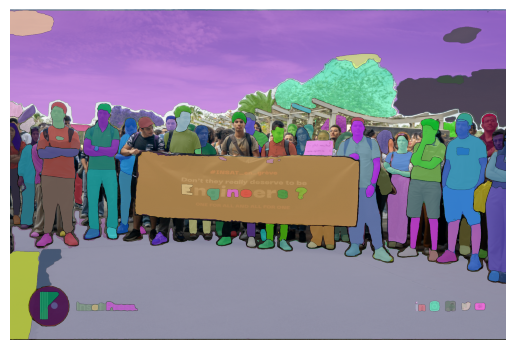

In [15]:
show_pipe_masks_on_image(raw_image, outputs)


one drawback of this method is that it takes too much time in inference so it is not practical. A possible solution is :

**Faster Inference: Infer an Image and a Single Point**

In [16]:
from transformers import AutoProcessor, AutoModelForMaskGeneration

processor = AutoProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")
model = AutoModelForMaskGeneration.from_pretrained("Zigeng/SlimSAM-uniform-77")  

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

Let's segment the banner containing "INSAT en grève" . We can do this by passing any point in this region

In [17]:
input_points = [[[721, 643]]]

In [18]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

 The torch.no_grad() context manager is used to disable gradient tracking, as the goal is inference rather than training.

In [19]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

In [20]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [21]:
len(predicted_masks)

1

In [22]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1365, 2048])

The pre-trained SAM model produces a single predicted mask with 3 channels and dimensions of 855 x 1300 pixels. Finally, let's print the iou scores.

In [23]:
outputs.iou_scores


tensor([[[0.9615, 0.9876, 0.8918]]])

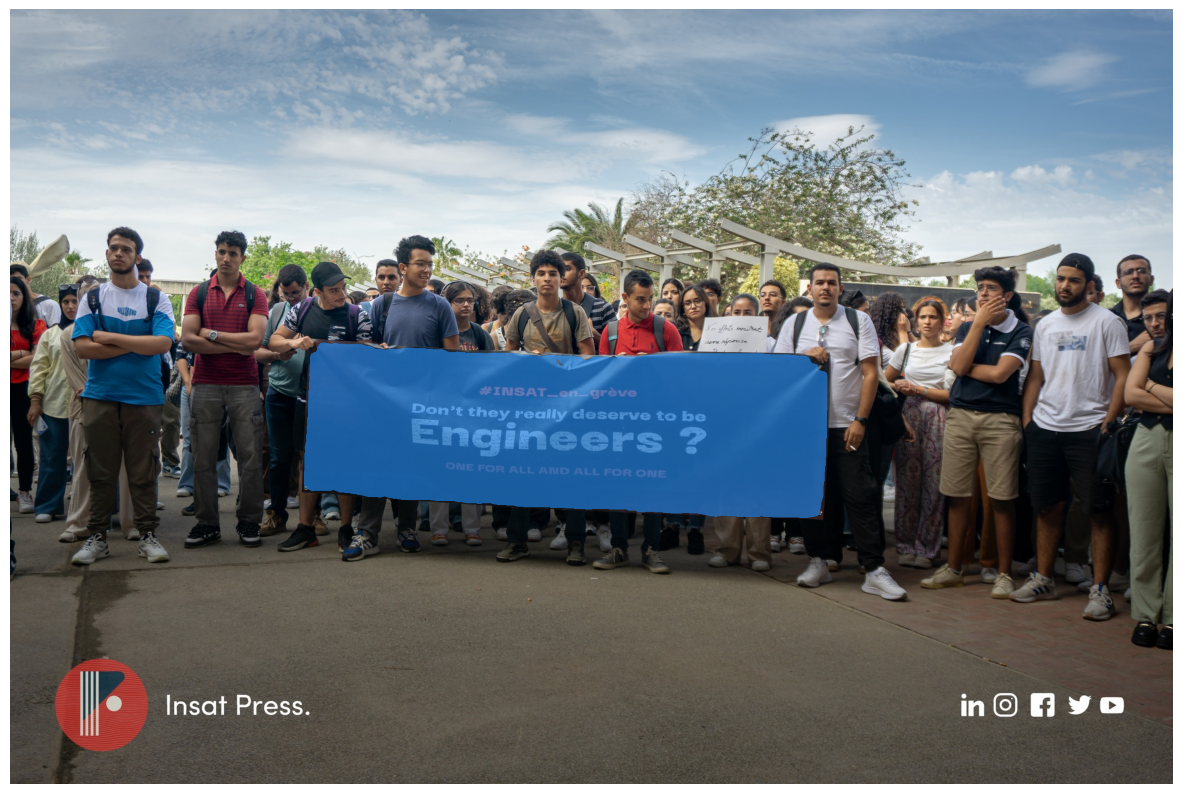

In [25]:
show_mask_on_image(raw_image, predicted_mask[:, 1])